In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
from collections import OrderedDict
import torch
from torch.utils.data import DataLoader, Sampler
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
plt.style.use('seaborn-v0_8')

## Sinusoidal Functional

In [3]:
nsize = 100
sample_size = 20
seed = 0
epsilon = 1/np.sqrt(30)
state = np.random.RandomState(seed)

In [4]:
np.random.seed(seed)

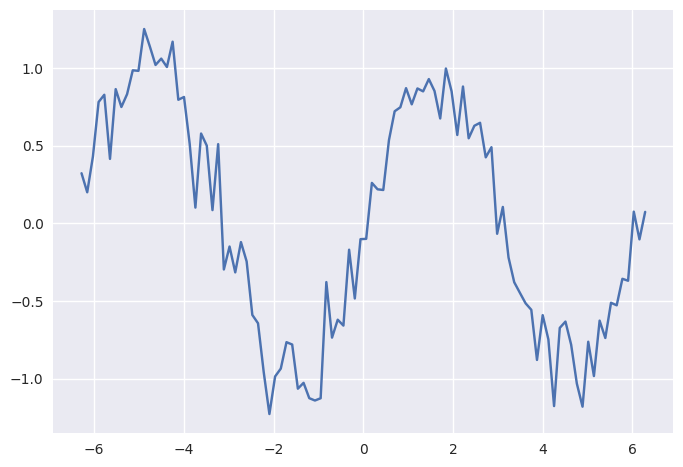

In [5]:
x = np.linspace(-2*np.pi, 2*np.pi, nsize)
y = np.sin(x) +  np.random.normal(loc=0, scale=epsilon,size=(nsize, ))
plt.plot(x, y)

In [6]:
sample_points = np.random.choice(nsize, sample_size, replace=False)
sample_points = np.sort(sample_points)

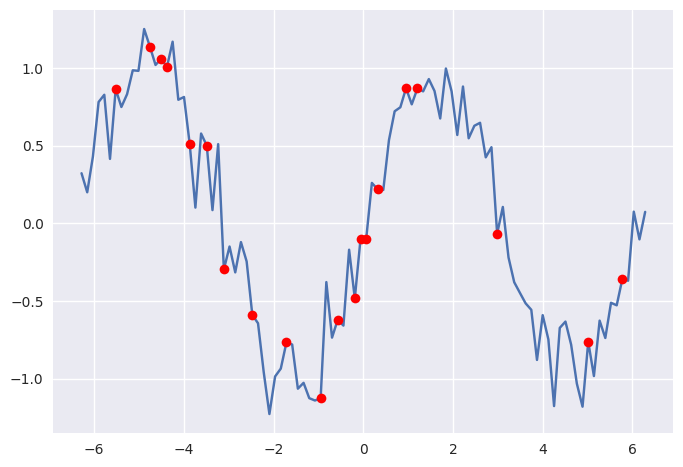

In [7]:
plt.plot(x, y)
plt.plot(x[sample_points], y[sample_points], 'ro')

In [8]:
def exp_squared_kernel(x, sigma_div=1.0, sigma_mul=1.0):
    assert len(x.shape) == 2
    exponent = x[:, None, :]  - x[None, : ]
    exponent = np.square(exponent).sum(axis=-1)
    exponent = -1 * exponent
    exponent /= (2 * np.square(sigma_div))
    
    kernel = np.square(sigma_mul) * np.exp(exponent)
    
    return kernel

In [9]:
kernel = exp_squared_kernel(np.random.rand(4, 3))

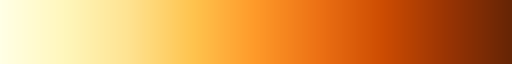

In [10]:
plt.cm.YlOrBr

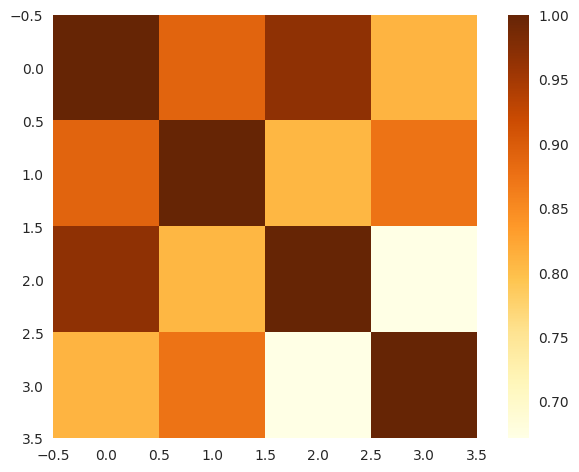

In [11]:
plt.imshow(kernel, cmap=plt.cm.YlOrBr)
plt.colorbar()
plt.grid(False)

In [12]:
kernel

array([[1.        , 0.88996579, 0.96532651, 0.80926417],
       [0.88996579, 1.        , 0.80729556, 0.87325675],
       [0.96532651, 0.80729556, 1.        , 0.67121407],
       [0.80926417, 0.87325675, 0.67121407, 1.        ]])

In [13]:
gp_x = x[sample_points][:, None]

In [14]:
gp_x

array([[-5.52158709],
       [-4.75998887],
       [-4.5061228 ],
       [-4.37918976],
       [-3.87145761],
       [-3.4906585 ],
       [-3.10985939],
       [-2.47519421],
       [-1.71359599],
       [-0.95199777],
       [-0.57119866],
       [-0.19039955],
       [-0.06346652],
       [ 0.06346652],
       [ 0.31733259],
       [ 0.95199777],
       [ 1.20586385],
       [ 2.98292636],
       [ 5.01385494],
       [ 5.77545316]])

In [15]:
kernel = exp_squared_kernel(gp_x)

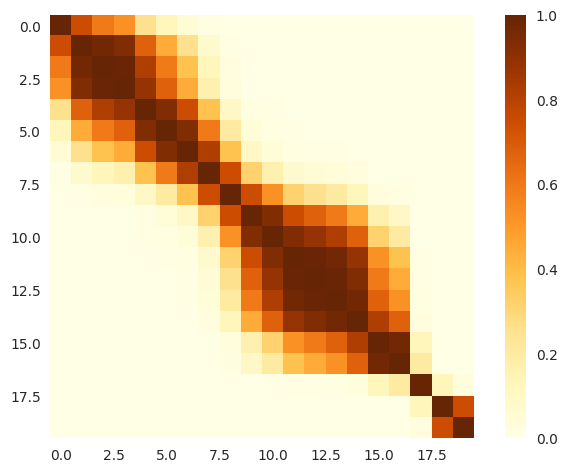

In [16]:
plt.imshow(kernel, cmap=plt.cm.YlOrBr)
plt.colorbar()
plt.grid(False)

In [17]:
kernel_chol = np.linalg.cholesky(kernel)

In [18]:
kernel_chol.shape

(20, 20)

In [19]:
kernel.shape

(20, 20)

In [20]:
np.max((kernel_chol @ kernel_chol.T) - kernel)

2.220446049250313e-16

In [21]:
gp_y = y[sample_points] + kernel_chol @ np.random.normal(0, 1, (sample_size))

In [22]:
gp_y

array([ 2.67589528,  0.97194533,  0.44290835,  0.22386584, -0.64338601,
       -0.71695477, -1.30690269, -0.73867345, -0.60153422, -0.95707282,
       -0.21288713,  0.12405017,  0.53896639,  0.55496169,  0.84888682,
        1.29915845,  1.23402817,  0.17387202, -0.5185749 , -1.22984752])

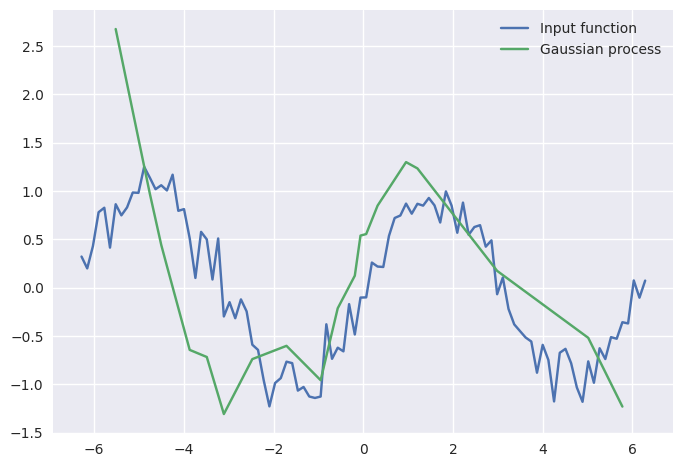

In [23]:
plt.plot(x, y, label='Input function')
plt.plot(gp_x.flatten(), gp_y, label='Gaussian process')
plt.legend()

In [24]:
# def exp_squared_kernel(x, sigma_div=1.0, sigma_mul=1.0):
#     assert len(x.shape) == 2
#     exponent = x[:, None, :]  - x[None, : ]
#     exponent = np.power(exponent, 2).sum(axis=-1)
#     exponent /= sigma_div ** 2
    
#     kernel = np.square(sigma_mul) * np.exp(-exponent)
    
#     return kernel

In [25]:
gp_x = x[:, np.newaxis]
gp_y = y.copy()

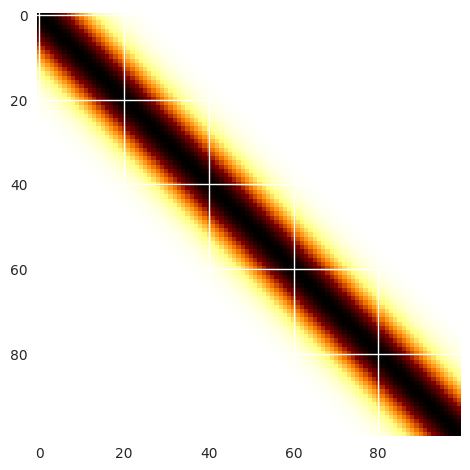

In [26]:
kernel = exp_squared_kernel(gp_x, sigma_div=1)
plt.imshow(kernel, cmap=plt.cm.afmhot_r)

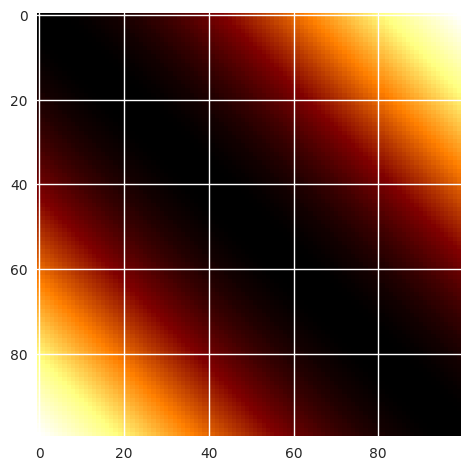

In [27]:
kernel = exp_squared_kernel(gp_x, sigma_div=10)
plt.imshow(kernel, cmap=plt.cm.afmhot_r)

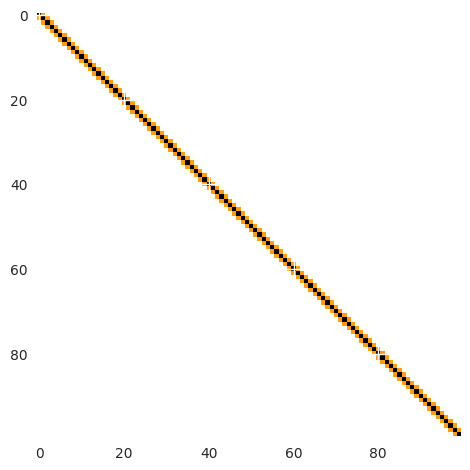

In [28]:
kernel = exp_squared_kernel(gp_x, sigma_div=.1)
plt.imshow(kernel, cmap=plt.cm.afmhot_r)


[[1.00000000e+00 1.79189038e-09 1.03096934e-35 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.79189038e-09 1.00000000e+00 1.79189038e-09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.03096934e-35 1.79189038e-09 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  1.79189038e-09 1.03096934e-35]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.79189038e-09
  1.00000000e+00 1.79189038e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.03096934e-35
  1.79189038e-09 1.00000000e+00]] 1.0


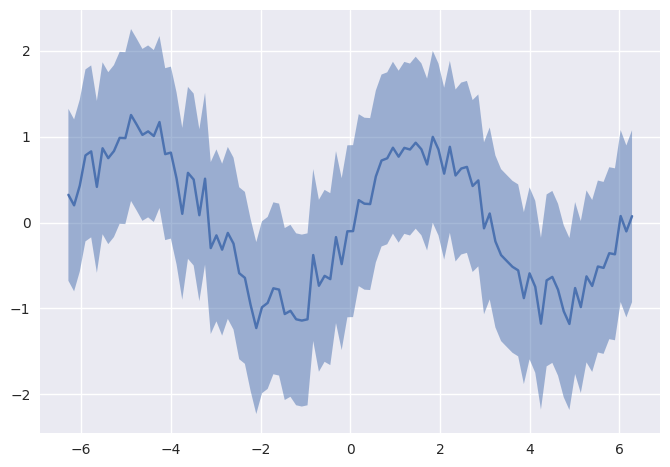

In [29]:
kernel = exp_squared_kernel(gp_x, sigma_div=0.02)
print(kernel, np.linalg.det(kernel))
kernel_chol = np.linalg.cholesky(kernel)
gp_y1 = gp_y + kernel_chol @ -np.ones((gp_x.shape[0], ))
gp_y2 = gp_y + kernel_chol @ np.ones((gp_x.shape[0], ))
plt.plot(x, y)
plt.fill_between(gp_x.ravel(), gp_y1, gp_y2, alpha=0.5, cmap=plt.cm.coolwarm_r)

[[1.         0.81758538 0.44681985 ... 0.         0.         0.        ]
 [0.81758538 1.         0.81758538 ... 0.         0.         0.        ]
 [0.44681985 0.81758538 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.81758538 0.44681985]
 [0.         0.         0.         ... 0.81758538 1.         0.81758538]
 [0.         0.         0.         ... 0.44681985 0.81758538 1.        ]] 1.3842740180869327e-114


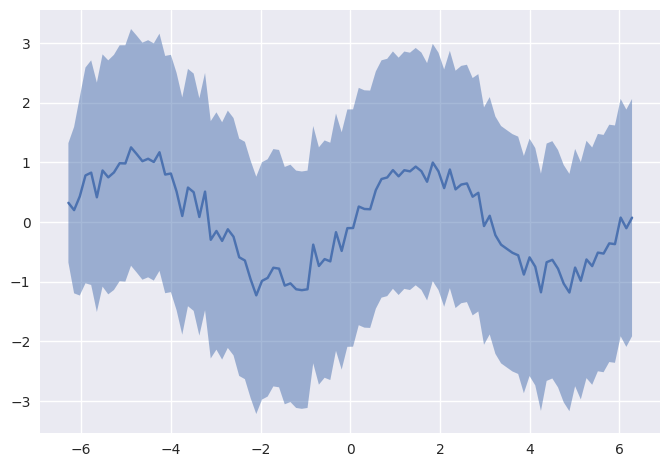

In [30]:
kernel = exp_squared_kernel(gp_x, sigma_div=0.2)
print(kernel, np.linalg.det(kernel))
kernel_chol = np.linalg.cholesky(kernel)
gp_y1 = gp_y + kernel_chol @ -np.ones((gp_x.shape[0], ))
gp_y2 = gp_y + kernel_chol @ np.ones((gp_x.shape[0], ))
plt.plot(x, y)
plt.fill_between(gp_x.ravel(), gp_y1, gp_y2, alpha=0.5, cmap=plt.cm.coolwarm_r)

[[1.00000000e+000 9.36352521e-001 7.68701161e-001 ... 1.87571456e-269
  5.05646128e-275 1.19510315e-280]
 [9.36352521e-001 1.00000000e+000 9.36352521e-001 ... 6.10050213e-264
  1.87571456e-269 5.05646128e-275]
 [7.68701161e-001 9.36352521e-001 1.00000000e+000 ... 1.73957511e-258
  6.10050213e-264 1.87571456e-269]
 ...
 [1.87571456e-269 6.10050213e-264 1.73957511e-258 ... 1.00000000e+000
  9.36352521e-001 7.68701161e-001]
 [5.05646128e-275 1.87571456e-269 6.10050213e-264 ... 9.36352521e-001
  1.00000000e+000 9.36352521e-001]
 [1.19510315e-280 5.05646128e-275 1.87571456e-269 ... 7.68701161e-001
  9.36352521e-001 1.00000000e+000]] 0.0


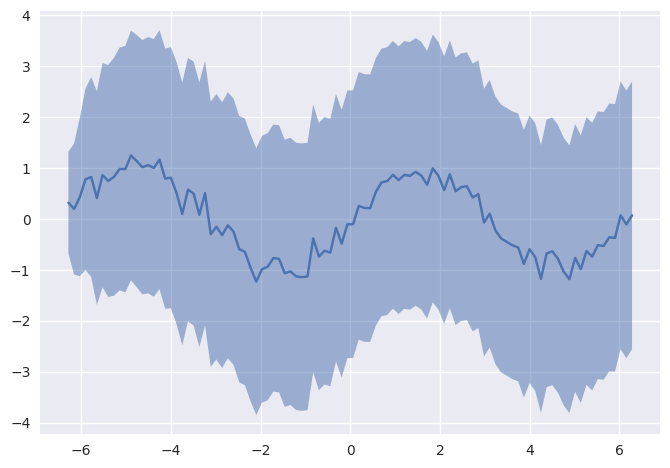

In [31]:
kernel = exp_squared_kernel(gp_x, sigma_div=0.35)
print(kernel, np.linalg.det(kernel))
kernel_chol = np.linalg.cholesky(kernel)
gp_y1 = gp_y + kernel_chol @ -np.ones((gp_x.shape[0], ))
gp_y2 = gp_y + kernel_chol @ np.ones((gp_x.shape[0], ))
plt.plot(x, y)
plt.fill_between(gp_x.ravel(), gp_y1, gp_y2, alpha=0.5, cmap=plt.cm.coolwarm_r)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 1.0


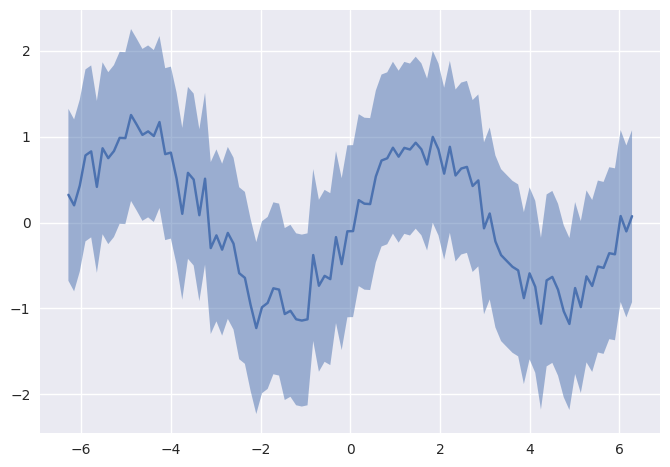

In [32]:
kernel = exp_squared_kernel(gp_x, sigma_div=1e-6, sigma_mul=1)
print(kernel, np.linalg.det(kernel))
kernel_chol = np.linalg.cholesky(kernel)
gp_y1 = gp_y + kernel_chol @ -np.ones((gp_x.shape[0], ))
gp_y2 = gp_y + kernel_chol @ np.ones((gp_x.shape[0], ))
plt.plot(x, y)
plt.fill_between(gp_x.ravel(), gp_y1, gp_y2, alpha=0.5, cmap=plt.cm.coolwarm_r)

[[0.0625 0.     0.     ... 0.     0.     0.    ]
 [0.     0.0625 0.     ... 0.     0.     0.    ]
 [0.     0.     0.0625 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.0625 0.     0.    ]
 [0.     0.     0.     ... 0.     0.0625 0.    ]
 [0.     0.     0.     ... 0.     0.     0.0625]] 3.872591914848412e-121


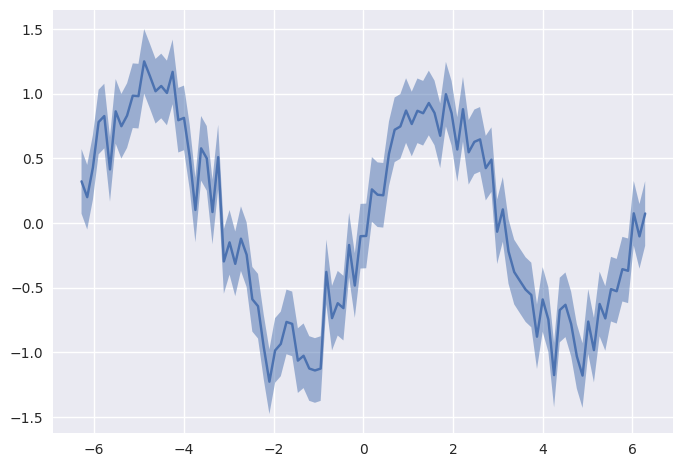

In [33]:
kernel = exp_squared_kernel(gp_x, sigma_div=1e-6, sigma_mul=0.25)
print(kernel, np.linalg.det(kernel))
kernel_chol = np.linalg.cholesky(kernel)
gp_y1 = gp_y + kernel_chol @ -np.ones((gp_x.shape[0], ))
gp_y2 = gp_y + kernel_chol @ np.ones((gp_x.shape[0], ))
plt.plot(x, y)
plt.fill_between(gp_x.ravel(), gp_y1, gp_y2, alpha=0.5, cmap=plt.cm.coolwarm_r)

## Gaussian Process

In [34]:
def cosine_kernel(X, x, p=1):
    r = x[:, None, ...]- X[None, ...]
    r = np.abs(r)
    r = r.sum(axis=-1)
    kernel = np.cos(2 * np.pi * r / p)   
    kernel = np.square(kernel)
    return kernel


In [35]:
np.random.seed(6)
sample_test = np.sort( np.random.uniform(-20, 20, (40, 1)), axis=0)
x_test = np.random.uniform(-6, 6, (1, ))[:, None]
sample_test, x_test

(array([[-18.33213497],
        [-17.82101969],
        [-15.6937328 ],
        [-15.00703302],
        [-11.32195359],
        [ -9.8546361 ],
        [ -9.77543778],
        [ -6.72080779],
        [ -6.58368603],
        [ -5.92760926],
        [ -3.90109964],
        [ -3.86974805],
        [ -3.47196261],
        [ -3.24770286],
        [ -2.47434296],
        [  0.72145648],
        [  1.19269449],
        [  1.63747417],
        [  3.15434401],
        [  3.80208257],
        [  3.96023653],
        [  4.90077729],
        [  5.81420384],
        [  6.85237728],
        [  8.36527003],
        [  8.69103386],
        [  8.69328582],
        [  8.74548946],
        [  9.43528425],
        [  9.45626575],
        [ 12.0868225 ],
        [ 12.79432788],
        [ 12.84916492],
        [ 12.9503773 ],
        [ 15.05070621],
        [ 15.71440606],
        [ 17.49398139],
        [ 18.30589182],
        [ 19.60897085],
        [ 19.76829754]]),
 array([[2.95812861]]))

In [36]:
k = cosine_kernel(sample_test, x_test, 30)

In [37]:
k

array([[0.06283269, 0.12437047, 0.52054831, 0.66143121, 0.97743739,
        0.8044247 , 0.79110117, 0.19419832, 0.17199387, 0.08189381,
        0.01790256, 0.01968542, 0.04937755, 0.07168646, 0.17607752,
        0.79614631, 0.86940169, 0.92542524, 0.99831213, 0.96908088,
        0.95659298, 0.84339429, 0.68287864, 0.46980701, 0.18013698,
        0.13083279, 0.13051486, 0.12323746, 0.04519419, 0.0433861 ,
        0.11191436, 0.22090137, 0.2305034 , 0.24859539, 0.67282814,
        0.79495526, 0.9905798 , 0.99470439, 0.88514416, 0.86302308]])

In [38]:
sample_test.squeeze()

array([-18.33213497, -17.82101969, -15.6937328 , -15.00703302,
       -11.32195359,  -9.8546361 ,  -9.77543778,  -6.72080779,
        -6.58368603,  -5.92760926,  -3.90109964,  -3.86974805,
        -3.47196261,  -3.24770286,  -2.47434296,   0.72145648,
         1.19269449,   1.63747417,   3.15434401,   3.80208257,
         3.96023653,   4.90077729,   5.81420384,   6.85237728,
         8.36527003,   8.69103386,   8.69328582,   8.74548946,
         9.43528425,   9.45626575,  12.0868225 ,  12.79432788,
        12.84916492,  12.9503773 ,  15.05070621,  15.71440606,
        17.49398139,  18.30589182,  19.60897085,  19.76829754])

In [39]:
x_test

array([[2.95812861]])

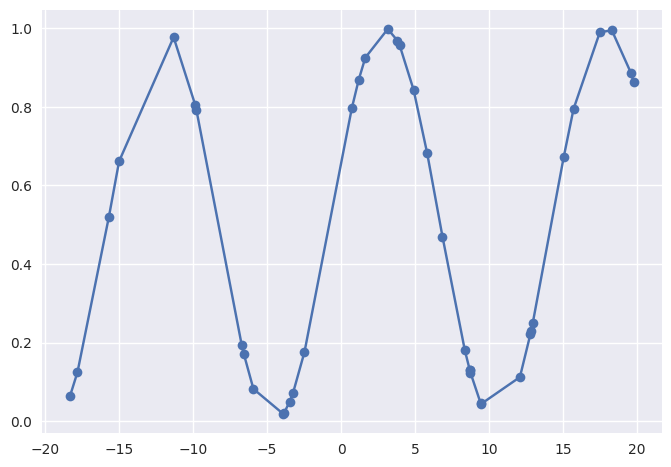

In [40]:
plt.plot(sample_test.ravel(), k.ravel(), marker="o")

In [41]:
%load_ext autoreload
%autoreload 2

from gp import GaussianProcess, ExpSquaredKernel, CosineKernel, LinearKernel, ConstantKernel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def plot_kernel(kernel, label):
    x = np.random.uniform(-10, 10, (100, 1))
    x = np.sort(x,axis=0)
    y = kernel(torch.from_numpy(x), torch.from_numpy(x[:1]))
    fig, ax = plt.subplots()
    ax.plot(x.ravel(), y.ravel(), label=label)
    ax.legend()

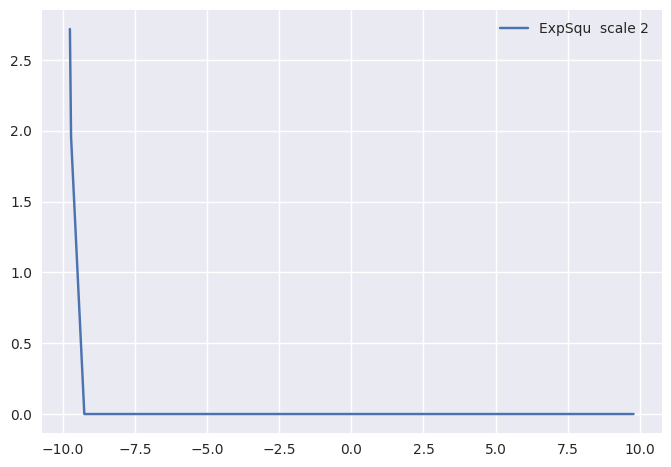

In [43]:
kernel = ExpSquaredKernel(length=torch.tensor(3.0))
plot_kernel(kernel, label='ExpSqu  scale 2')

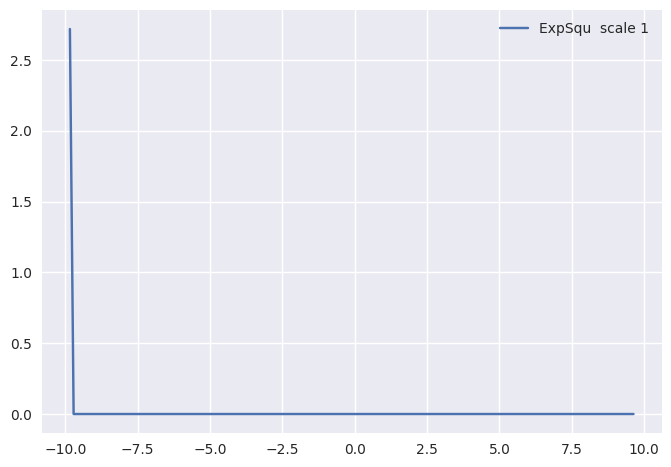

In [44]:
kernel = ExpSquaredKernel(scale=1.0, length=torch.tensor(20.0))
plot_kernel(kernel, label='ExpSqu  scale 1')

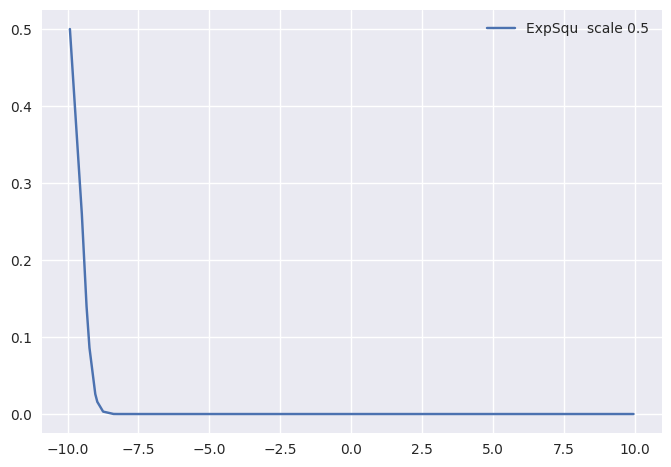

In [45]:
kernel = ExpSquaredKernel(scale=torch.log(torch.tensor(0.5)))
plot_kernel(kernel, label='ExpSqu  scale 0.5')

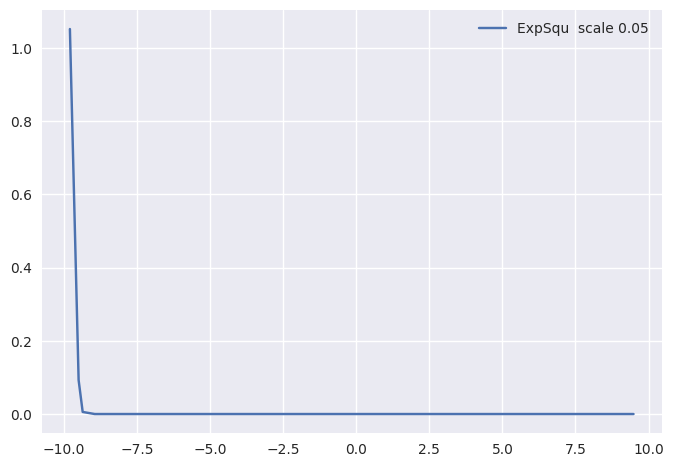

In [46]:
kernel = ExpSquaredKernel(scale=0.05, length=2)
plot_kernel(kernel, label='ExpSqu  scale 0.05')

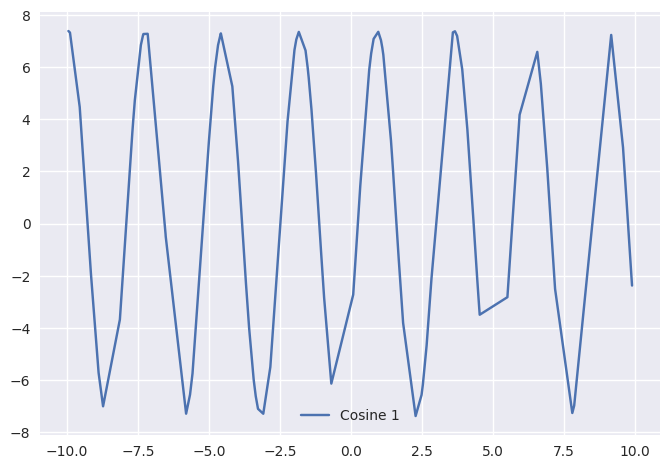

In [47]:
kernel = CosineKernel(p=1)
plot_kernel(kernel, label='Cosine 1')

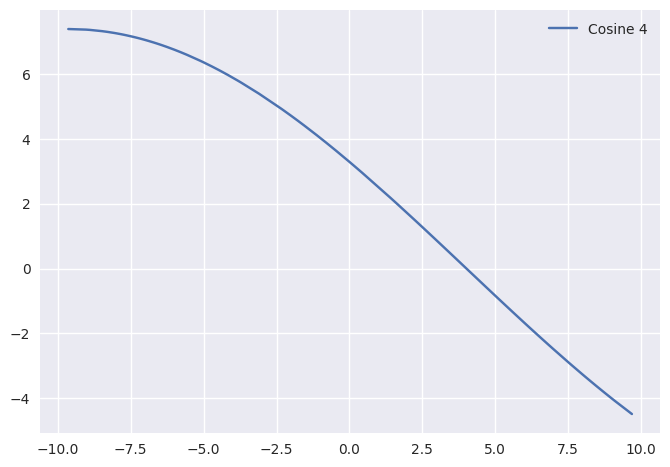

In [48]:
kernel = CosineKernel(p=4)
plot_kernel(kernel, label='Cosine 4')

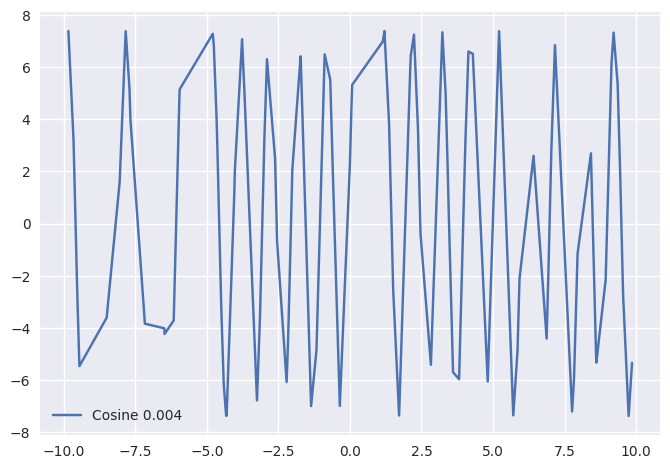

In [49]:
kernel = CosineKernel(p=0.004)
plot_kernel(kernel, label='Cosine 0.004')

In [50]:
def plot_gp_exp(scale):
    kernel = ExpSquaredKernel(scale=scale)
    np.random.seed(seed)
    X = np.sort(np.random.uniform(0, 10, (10, 1)), axis=0)
    gp = GaussianProcess(kernel=kernel, X =torch.from_numpy(X,).float(), diag=torch.diag(torch.tensor([1e-5] * 10)))
    y = gp.sample(5)
    for t in y.chunk(5, axis=1):
        plt.plot(X, t.ravel())

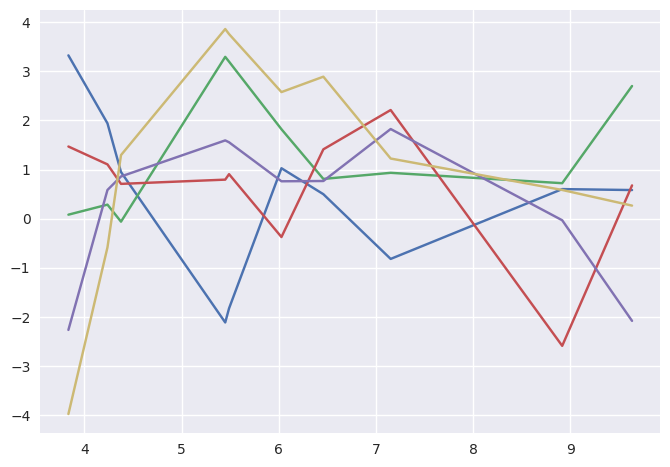

In [51]:
plot_gp_exp(1)

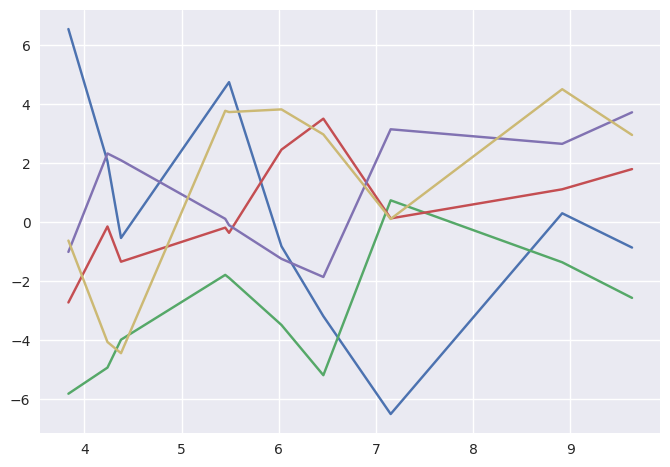

In [52]:
plot_gp_exp(2)

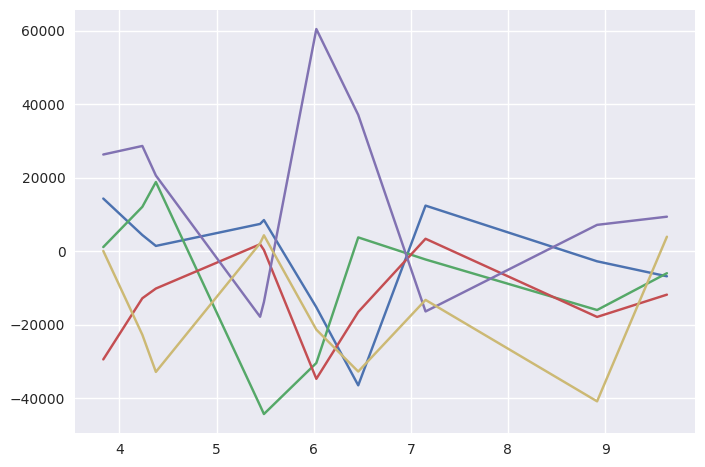

In [53]:
plot_gp_exp(20)

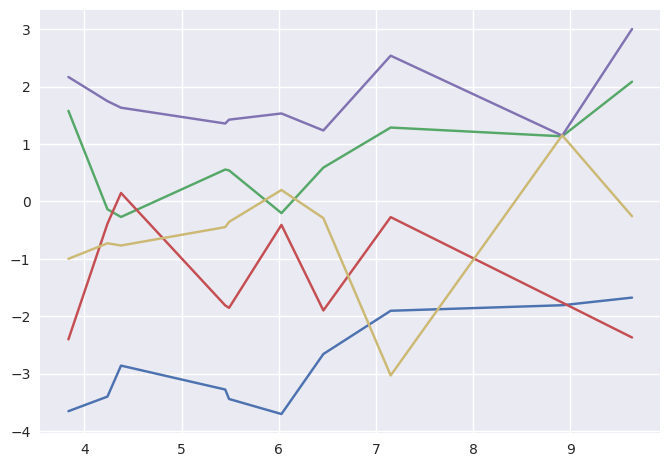

In [54]:
plot_gp_exp(0.2)

In [55]:
def plot_gp_exp_with_mean(scale, sample_num = 1):
    size = 60
    kernel = ExpSquaredKernel(scale=scale)
    X = np.linspace(-6*np.pi, 6*np.pi, size)[:, None]
    mean = np.sin(X)
    gp = GaussianProcess(kernel=kernel, X =torch.from_numpy(X,).float(), mean=torch.from_numpy(mean).float(), diag=torch.diag(torch.tensor([1e-5] * size)))
    y = gp.sample(sample_num)
    plt.plot(X.ravel(), mean.ravel(), ls='--', lw=8)
    for t in y.chunk(sample_num, axis=1):
        plt.plot(X, t.ravel())

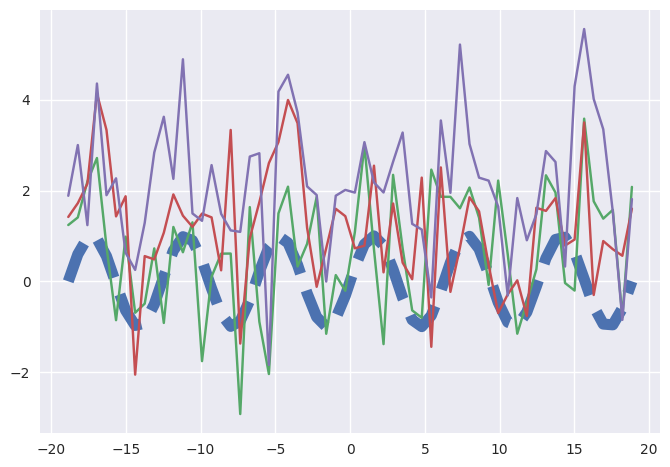

In [56]:
plot_gp_exp_with_mean(0.5, 3)

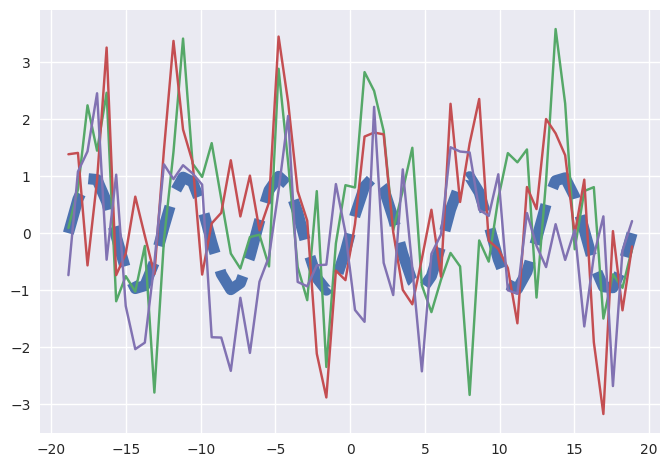

In [57]:
plot_gp_exp_with_mean(0.003, 3)

In [58]:
size = 10
for scale in np.linspace(0.3, 1, 5):
    kernel = ExpSquaredKernel(scale=scale)
    X = np.linspace(-6*np.pi, 6*np.pi, size)[:, None]
    mean = np.sin(X)
    gp = GaussianProcess(kernel=kernel, X =torch.from_numpy(X,).float(), mean=torch.from_numpy(mean).float(), diag=torch.diag(torch.tensor([6e-5] * size)))
    y = gp.sample(5)
    print("Scale:  ", scale, " , Log proba: ", gp.log_probability(y, mean))

Scale:   0.3  , Log proba:  tensor([-13.3823, -13.8802, -13.2359, -14.2871, -12.9540], dtype=torch.float64)
Scale:   0.475  , Log proba:  tensor([-14.1197, -15.3346, -13.9127, -15.9059, -15.8642], dtype=torch.float64)
Scale:   0.6499999999999999  , Log proba:  tensor([-12.2630, -14.1630, -16.9073, -15.4600, -15.9262], dtype=torch.float64)
Scale:   0.825  , Log proba:  tensor([-14.9955, -16.6009, -15.0519, -16.1112, -23.3131], dtype=torch.float64)
Scale:   1.0  , Log proba:  tensor([-16.3261, -13.3542, -18.4961, -14.8254, -14.7486], dtype=torch.float64)


## SGD Kernel learning

In [59]:
# %load_ext autoreload
# %autoreload 2

# from gp import GaussianProcess, ExpSquaredKernel, CosineKernel
# import torch
# import numpy as np

In [73]:
class KernelMLP(torch.nn.Module):
    
    def __init__(self, size=10) -> None:
        super().__init__()
        self.scale = torch.nn.Parameter(torch.log(torch.Tensor([2.0])))
        self.length = torch.nn.Parameter(torch.log(torch.Tensor([4.0])))
        self.kernel = ExpSquaredKernel(scale=self.scale, length=self.length)
        np.random.seed(0)
        torch.manual_seed(0)
        X = np.linspace(-6*np.pi, 6*np.pi, size)[:, None]
        self.mean = np.sin(X)
        diag = torch.Tensor(torch.diag(torch.log(torch.tensor([1e-6] * X.shape[0])))).float()
        diag[diag.eq(0.)] = -1e8
        self.gp = GaussianProcess(kernel=self.kernel, X =torch.from_numpy(X,).float(), 
                                  mean=torch.from_numpy(self.mean).float(), 
                                  diag=diag)
        

    def forward(self):
        
        y = self.gp.sample(512)
        return y

In [74]:
net = KernelMLP(100)

In [75]:
list(net.parameters())


[Parameter containing:
 tensor([0.6931], requires_grad=True),
 Parameter containing:
 tensor([1.3863], requires_grad=True)]

In [76]:
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [77]:
losses = []
epochs = 10000
mean = torch.from_numpy(net.mean).float()

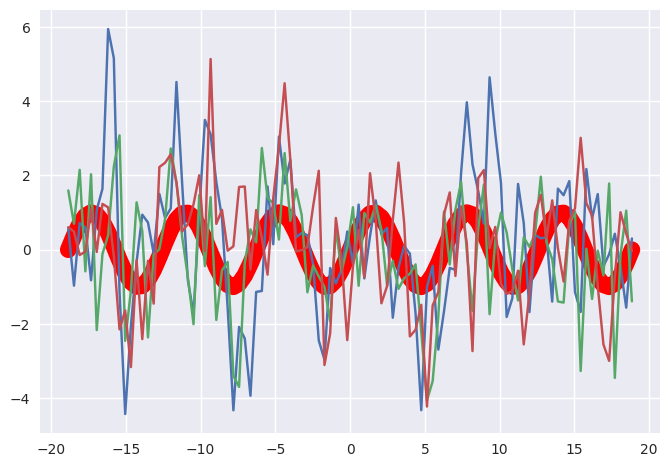

In [79]:
y = net.gp.sample(3)
plt.plot(net.gp.X, net.gp.mean, lw=12, color='red')
plt.plot(net.gp.X, y.cpu().detach().numpy())

In [80]:
for i in range(epochs):
    proba = net()
    log_proba = net.gp.log_probability(proba, mean)
    loss = -log_proba.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
    

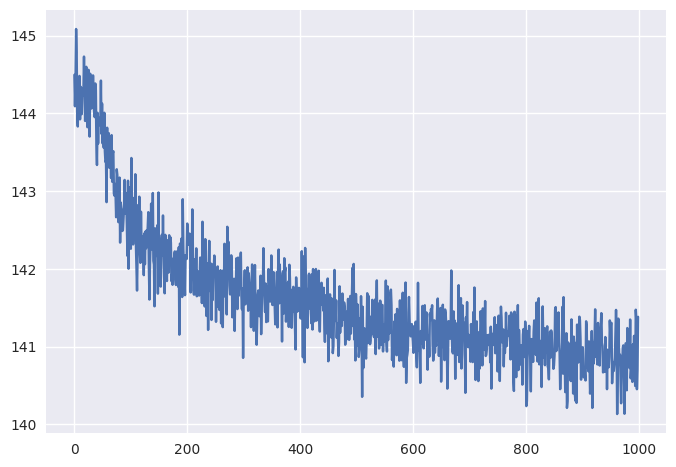

In [81]:
plt.plot(losses[::10])

In [82]:
list(net.parameters())

[Parameter containing:
 tensor([-7.4667], requires_grad=True),
 Parameter containing:
 tensor([-4.1425], requires_grad=True)]

In [83]:
net.gp.kernel.scale

Parameter containing:
tensor([-7.4667], requires_grad=True)

In [84]:
net.gp.kernel.length

Parameter containing:
tensor([-4.1425], requires_grad=True)

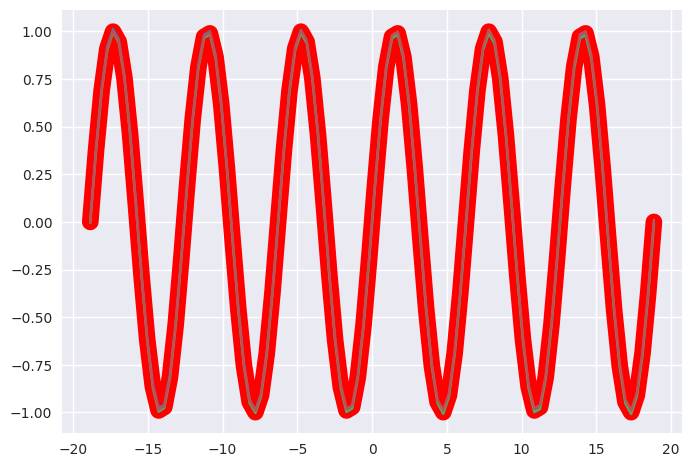

In [85]:
y = net.gp.sample(3)
plt.plot(net.gp.X, net.gp.mean, lw=12, color='red')
plt.plot(net.gp.X, y.cpu().detach().numpy())

In [86]:
losses = []
epochs = 400
net = KernelMLP(100)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

In [87]:
for i in range(epochs):
    proba = net()
    log_proba = net.gp.log_probability(proba, mean)
    loss = -log_proba.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
    

In [88]:
net.gp.kernel.scale

Parameter containing:
tensor([0.6531], requires_grad=True)

In [89]:
net.gp.kernel.length

Parameter containing:
tensor([1.3449], requires_grad=True)

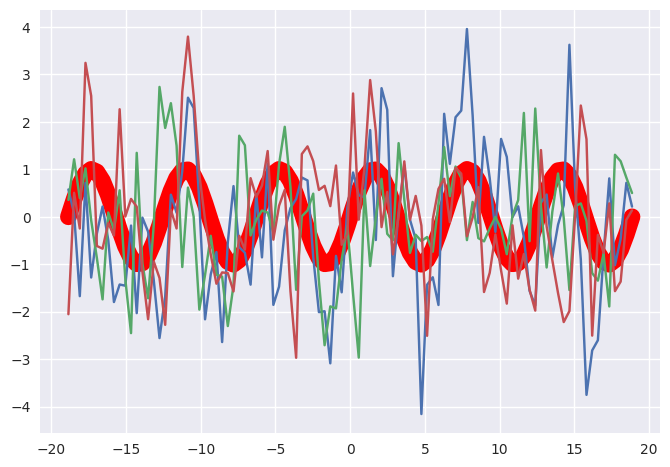

In [90]:
y = net.gp.sample(3)
plt.plot(net.gp.X, net.gp.mean, lw=12, color='red')
plt.plot(net.gp.X, y.cpu().detach().numpy())

## Training with MLP mean function

In [1]:
%load_ext autoreload
%autoreload 2
import os
from collections import OrderedDict
import torch
from torch import nn
from torch.utils.data import DataLoader, Sampler
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

from gp import GaussianProcess, ExpSquaredKernel, CosineKernel, LinearKernel,  ConstantKernel, Kernel

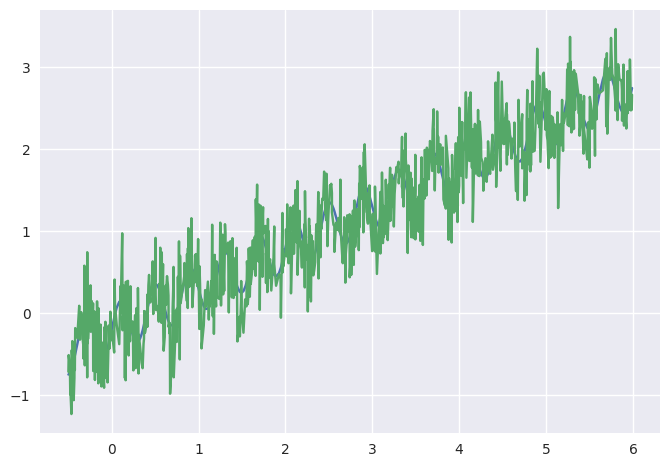

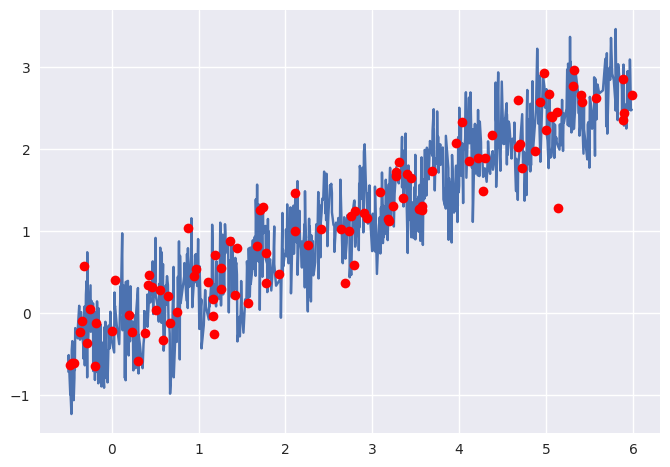

In [2]:
np.random.seed(65)
n = 1000
x = np.random.uniform(-0.5, 6, (n, 1), )
x = np.sort(x, axis=0)
epsilon = np.random.randn(x.shape[0])
y_true = 0.3 * np.sin(2*np.pi*x.ravel() / 0.4) + 0.5 * (x.ravel() - 0.4) 

y_true = y_true[:, None]

y =  y_true.ravel() - 0.3 * epsilon.ravel()
y = y[:, None]

fig, ax = plt.subplots()
plt.plot(x.ravel(), y_true.ravel())
plt.plot(x.ravel(), y.ravel())


split = np.random.permutation(n)
# split = np.sort(split)
train_split, test_split = split[:n - int(0.1 * n)], split[n - int(0.1 * n):]

train_split = sorted(train_split)
test_split = sorted(test_split)

x_train, y_train = x[train_split], y[train_split]
x_test, y_test = x[test_split], y[test_split]

fig, ax = plt.subplots()

plt.plot(x_train.ravel(), y_train.ravel())
plt.plot(x_test.ravel(), y_test.ravel(), 'ro')


In [3]:
class ModelGP(torch.nn.Module):
    
    def __init__(self, x_train, y_train, x_test, y_test):
        super().__init__()
        self.num_samples = x_train.shape[0]
        self.x_train = torch.from_numpy(x_train).float()
        self.y_train = torch.from_numpy(y_train).float()
         
        self.x_test = torch.from_numpy(x_test).float()
        self.y_test = torch.from_numpy(y_test).float()
        
        self.kernel1_length, self.kernel1_scale = torch.nn.Parameter(torch.log(torch.Tensor([0.01])).float()), \
                                                  torch.nn.Parameter(torch.log(torch.Tensor([0.01])).float())
        self.kernel1 = ExpSquaredKernel(length=self.kernel1_length, 
                                        scale=self.kernel1_scale, 
                                        ) + ConstantKernel(torch.log(torch.tensor([1e-3])))
        
        self.kernel2_p, self.kernel2_scale = torch.nn.Parameter(torch.log(torch.Tensor([0.001])).float()), \
                                                  torch.nn.Parameter(torch.log(torch.Tensor([0.001])).float())
        self.kernel2 = CosineKernel(p=self.kernel2_p, scale=self.kernel2_scale)

        self.lin_param = torch.nn.Parameter(torch.log(torch.Tensor([3.]).float()))
        # self.bias_param = torch.nn.Parameter(torch.log(torch.Tensor([1e-3]  * self.x_train.shape[0]).float()))
        self.bias_param = torch.nn.Parameter(torch.log(torch.Tensor([0.001]).float()))
        self.kernel3 = LinearKernel(self.lin_param, self.bias_param) * self.lin_param 
        
        self.kernel = self.kernel1 + self.kernel2 * self.kernel3
        
        self.mean_function = nn.Sequential(
            nn.Linear(1, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, 10),
            nn.Tanh(),
            nn.Linear(10, 1),
            nn.ReLU()
            )
        
        def apply_fn(layer):
            if isinstance(layer, nn.Linear):
                nn.init.uniform_(layer.weight, -1e-3, 1e-3)
                if layer.bias is not None:
                    layer.bias.data = layer.bias.data.new_zeros(layer.bias.size())
        with torch.no_grad():
            self.mean_function.apply(apply_fn)
        diag = torch.log(torch.tensor([1e1])).type_as(self.x_train)
        self.diag = torch.nn.Parameter(diag)
        self.gp = GaussianProcess(kernel=self.kernel, X=self.x_train, diag=self.diag, 
                                  mean_function=self.mean_function,
                                  )
    
    def forward(self, ):
        y = self.gp.sample(64)
        return y
        

In [4]:
model = ModelGP(x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)
# model = ModelGP(x_train=x_train, x_test=x_test, y_train=y[:x_train.shape[0]], y_test=y_test)

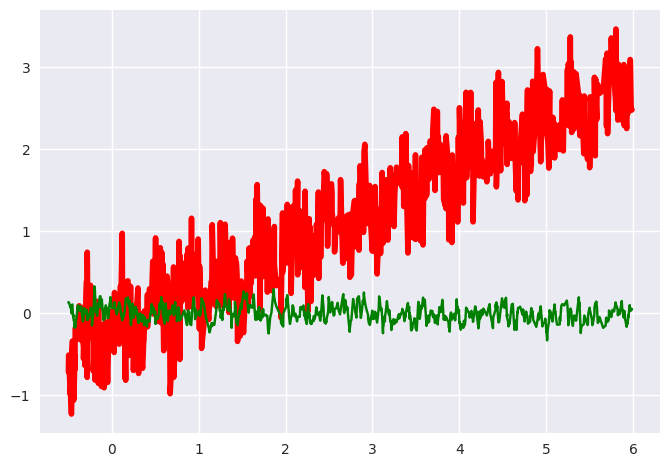

In [5]:
with torch.no_grad():
    pred = model.gp.sample(1)
    # plt.plot(x_train.ravel(), y_train.ravel(), lw=3, color='red')
    plt.plot(model.x_train.squeeze(), model.y_train.squeeze(), lw=4, color='red')
    plt.plot(model.x_train.squeeze(), pred.detach().squeeze().numpy(), color='g')

In [6]:
opt = torch.optim.Adam(model.parameters(), lr=5e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)
losses = []

In [7]:
epochs = 5000

In [8]:

for i in range(epochs):
    proba = model()
    log_proba = model.gp.log_probability(proba, model.y_train)
    loss = -log_proba.mean()
    opt.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 2.0)
    opt.step()
    scheduler.step()
    losses.append(loss.item())   

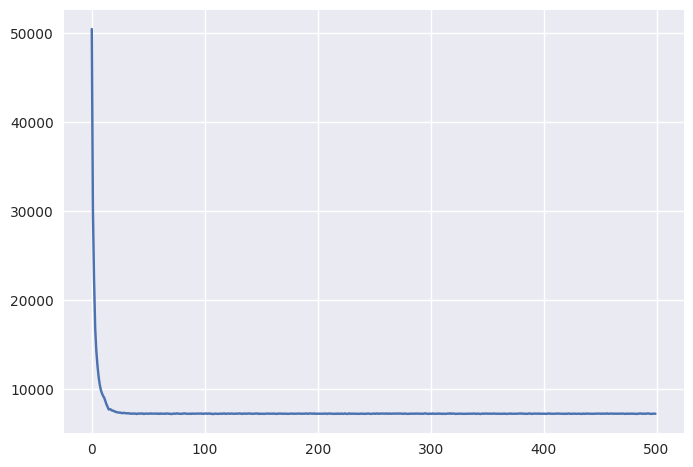

In [9]:
plt.plot(losses[::10])

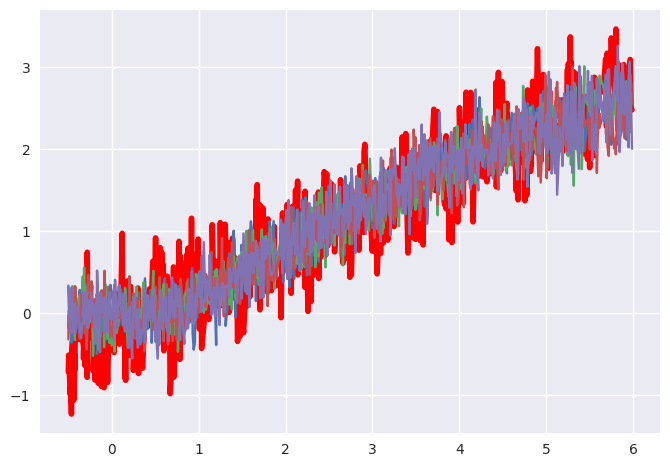

In [10]:
with torch.no_grad():
    plt.plot(model.x_train.squeeze(), model.y_train.squeeze(), lw=4, color='red')
    
    for i in range(4):
        pred = model.gp.sample(1)
        plt.plot(model.x_train.squeeze(), pred.detach().squeeze().numpy(), )

In [11]:
@torch.no_grad()
def evaluate(x_test, x_train, kernel_train, y_train, mean_train, kernel_chol):
    x_test = x_test.unsqueeze(0)
    kernel_test = model.gp.compute_kernel(x_test, x_test, mode='inference')
    kernel_train_test = model.gp.compute_kernel(x_train, x_test, mode='inference')
    alpha = model.gp.compute_alpha(y_train, mean_train, kernel_train)
    
    mean = model.gp.mean_function(x_test)
    x_test_mean = (kernel_train_test * alpha.unsqueeze(0)).sum(dim=(-1, ), keepdim=True)
    v = torch.linalg.solve_triangular(kernel_chol, kernel_train_test.transpose(0, 1), left=True, upper=False)
    v = v.t()
    variance = kernel_test - v @ v.t()
    noise = variance * torch.randn((1, 1)) 
    return (mean + x_test_mean + noise).squeeze(0)

with torch.no_grad():
    fn = torch.vmap(evaluate, (0, None, None, None, None, None),  randomness="different")
    mean_train = model.gp.mean_function(model.gp.X)
    y_train = model.gp.sample(1)
    kernel_train = model.gp.compute_kernel(model.gp.X, model.gp.X,)
    kernel_chol = torch.linalg.cholesky(kernel_train)
    y_eval = fn(model.x_test, model.x_train, kernel_train, y_train, mean_train, kernel_chol, )

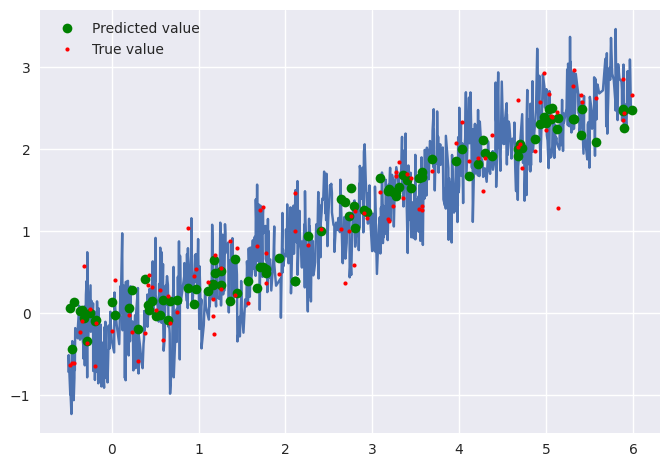

In [17]:
fig, ax = plt.subplots()

plt.plot(model.x_train.ravel(), model.y_train.ravel())
plt.plot(model.x_test.ravel(), y_eval.ravel(), 'go', label='Predicted value')
plt.plot(model.x_test.ravel(), y_test.ravel(), 'ro', label='True value', markersize=3)
plt.legend()